In [84]:
import shap
import streamlit as st
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [93]:
from ucimlrepo import fetch_ucirepo
def get_data():
    from sklearn.impute import SimpleImputer
    cervical_cancer_risk_factors = fetch_ucirepo(id=383) 
    df = cervical_cancer_risk_factors.data.features 
    df = df.dropna(thresh=len(df)*0.5, axis=1)
    # Remplacer les valeurs manquantes restantes par des médianes pour les colonnes numériques
    imputer = SimpleImputer(strategy="median")
    df.iloc[:, :] = imputer.fit_transform(df)
    return df

def get_data_original():
    df=get_data()
    cols_to_drop = ["Smokes (years)", "Hormonal Contraceptives (years)", "IUD (years)", "STDs: Number of diagnosis", "Dx"]
    df= df.drop(columns=[col for col in cols_to_drop if col in df.columns])
    return df

def load_and_clean_data():
    df= get_data()
    df= get_data_original()
    return df

In [94]:
df.shape

 Accuracy: 0.9419

 Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       161
           1       0.55      0.55      0.55        11

    accuracy                           0.94       172
   macro avg       0.76      0.76      0.76       172
weighted avg       0.94      0.94      0.94       172



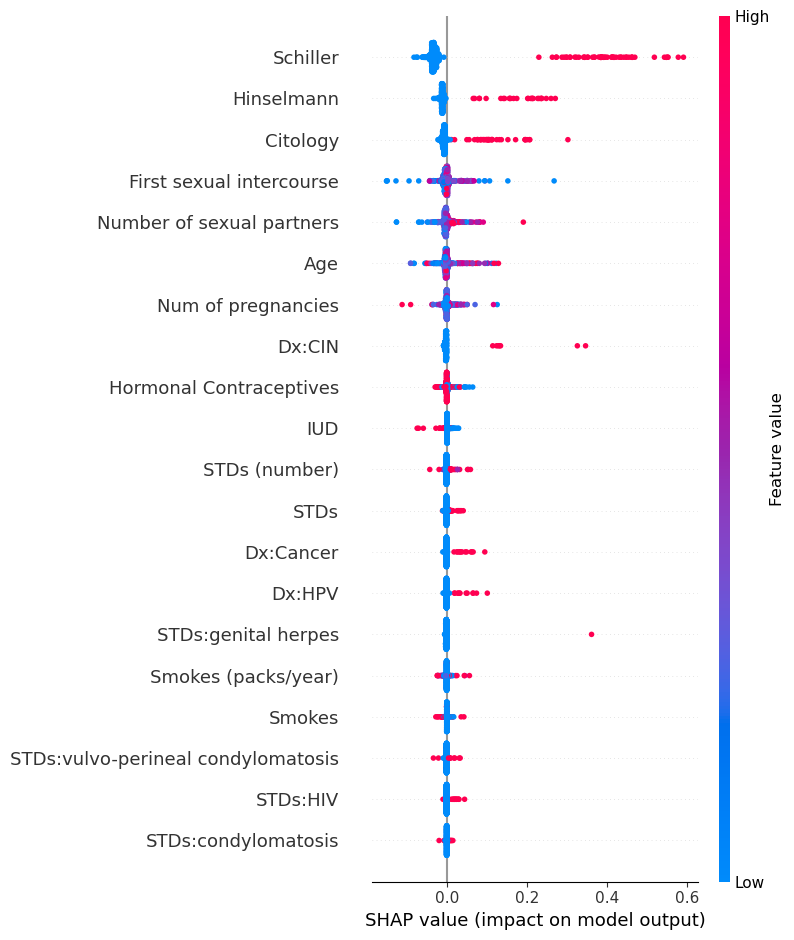

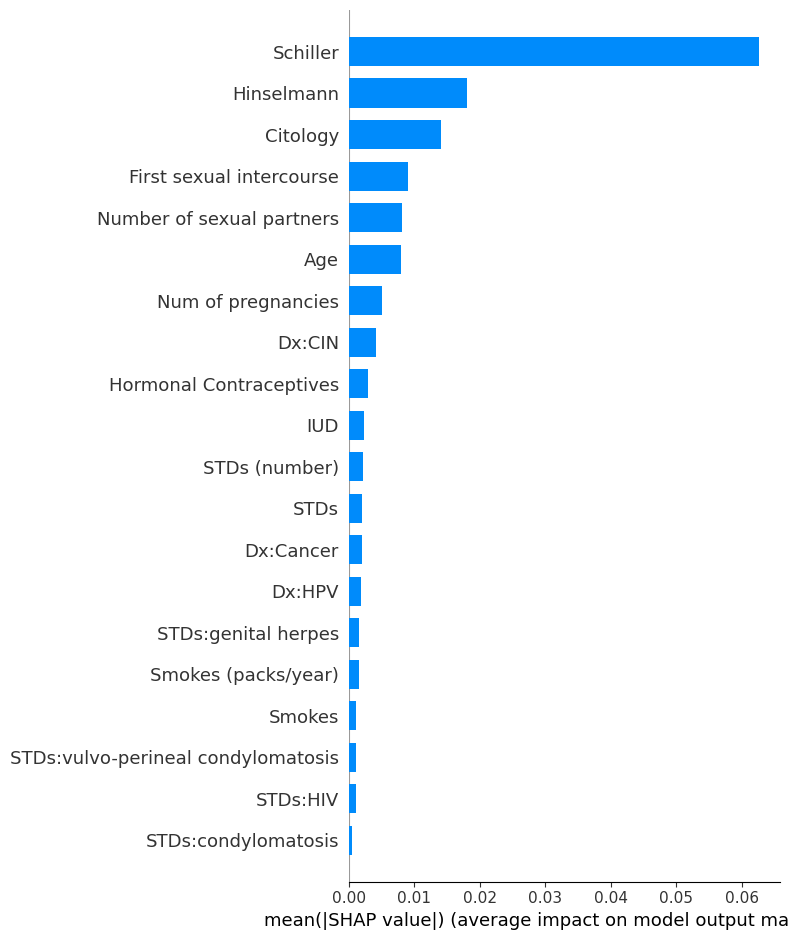

<Figure size 640x480 with 0 Axes>

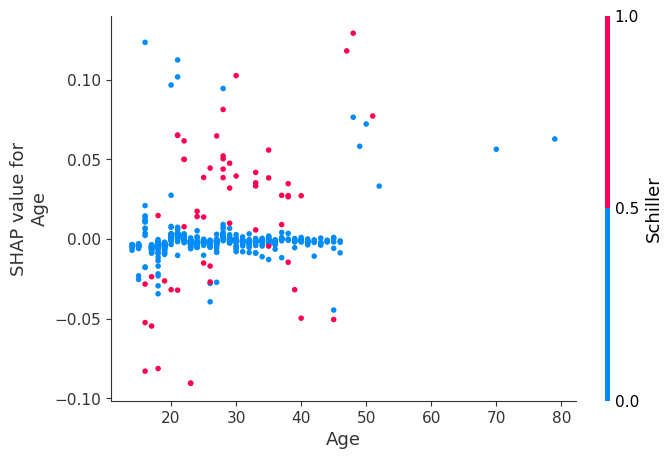

🔍 SHAP Force Plot sauvegardé sous 'force_plot.html'. Ouvrez-le dans un navigateur.


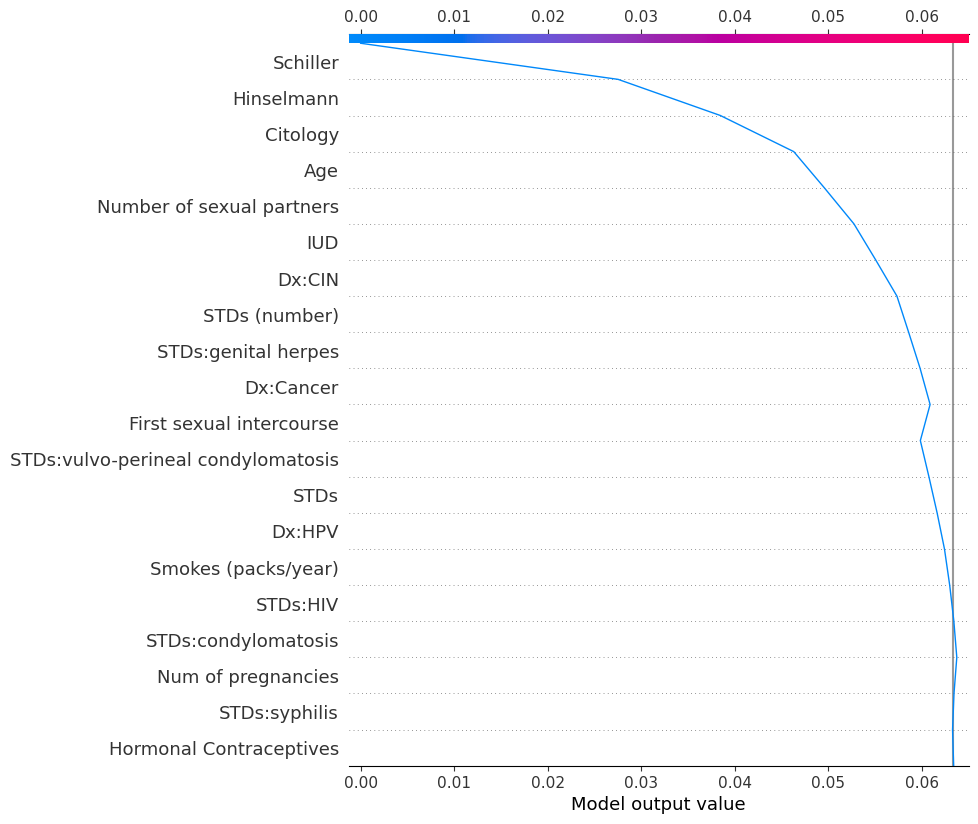

In [98]:
def prepare_data():
    """Divise les données en X (features) et y (target), puis les sépare en train/test."""
    df =load_and_clean_data()

    # Définition des features (X) et de la variable cible (y)
    X = df.drop(columns=["Biopsy"])  # Variable cible = Biopsy
    y = df["Biopsy"]

    # Division des données en train et test (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test
    
# Fonction pour entraîner le modèle Random Forest
def train_model(X_train, y_train):
    """Entraîne un Random Forest Classifier sur les données."""
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

# Fonction pour évaluer le modèle
def evaluate_model(model, X_test, y_test):
    """Évalue le modèle en affichant la précision et le rapport de classification."""
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f" Accuracy: {accuracy:.4f}")
    print("\n Classification Report:\n", classification_report(y_test, y_pred))

# Fonction pour expliquer les prédictions avec SHAP

def explain_model(model, X_train):
    """Génère plusieurs visualisations SHAP pour expliquer le modèle."""
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)

    # Vérifier si shap_values est une liste (cas classification binaire/multi-classe)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # On prend les SHAP values de la classe positive (1)
    
    # Si les SHAP values ont une dimension (686, 28, 2), on prend uniquement la classe 1
    if len(shap_values.shape) == 3:
        shap_values = shap_values[:, :, 1]

    # Vérification de la taille des SHAP values
    assert shap_values.shape == X_train.shape, f"Erreur : SHAP values {shap_values.shape} != X_train {X_train.shape}"

    # 1️⃣ SHAP Summary Plot (Impact global des features)
    plt.figure()
    shap.summary_plot(shap_values, X_train)
    plt.show()

    # 2️⃣ Feature Importance (Bar Chart)
    plt.figure()
    shap.summary_plot(shap_values, X_train, plot_type="bar")
    plt.show()

    # 3️⃣ Dependence Plot (Effet d'une feature spécifique sur les prédictions)
    feature_name = X_train.columns[0]  # On prend la première feature pour l'exemple
    plt.figure()
    shap.dependence_plot(feature_name, shap_values, X_train)
    plt.show()

    # 4️⃣ SHAP Force Plot (Visualisation individuelle d'une prédiction)
    sample_index = 0  # On prend la première ligne pour l'exemple
    shap.initjs()
    force_plot = shap.force_plot(explainer.expected_value[1], shap_values[sample_index], X_train.iloc[sample_index])
    shap.save_html("force_plot.html", force_plot)  # Sauvegarde en HTML
    print("🔍 SHAP Force Plot sauvegardé sous 'force_plot.html'. Ouvrez-le dans un navigateur.")

    # 5️⃣ SHAP Decision Plot (Processus de prise de décision du modèle)
    plt.figure()
    shap.decision_plot(explainer.expected_value[1], shap_values[sample_index], X_train.columns)
    plt.show()

# Exécution complète du pipeline 
X_train, X_test, y_train, y_test = prepare_data()  # Préparation des données
model = train_model(X_train, y_train)  # Entraînement du modèle
evaluate_model(model, X_test, y_test)  # Évaluation du modèle
explain_model(model, X_train)  # Explication avec SHAP